In [13]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import poisson

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MultipleLocator, MaxNLocator
import matplotlib.gridspec as gridspec
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt
from pytensor.tensor.special import gammaln

from tqdm.autonotebook import tqdm

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "legend.fontsize": 12,
    "legend.title_fontsize": 14,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 18,
})
mpl.rcParams['animation.embed_limit'] = 2000


## Generate the synthetic data

In [14]:
class insilico_experiment:
    """
        Parameters to be estimated in subsequent Bayesian inference:
        1. the average lambda (kill_lambda_avg)
        2. the std of lambda (kill_lambda_sd)
        3. the proportion of the non-killers (p_zero)
    """
    def __init__(
        self,
        kill_lambda_avg: float = 3.0,
        kill_lambda_sd: float = 1.0,
        lambda_dis_mode: str = "normal",  # "gamma", "lognormal", "normal", "halfnormal"
        Num_killers_obs: int = 300,
        p_zero: float = 0.0,             # optional zero-inflation on λ
        random_seed: int = 66
    ):
        self.kill_lambda_avg = kill_lambda_avg
        self.kill_lambda_sd = kill_lambda_sd
        self.lambda_dis_mode = lambda_dis_mode
        self.Num_killers_obs = Num_killers_obs
        self.p_zero = p_zero
        self.random_seed = random_seed
        
        self.lambdas, self.kills = self._generate_data()
    
    def _generate_data(self):
        rng = np.random.default_rng(self.random_seed)
        if self.lambda_dis_mode == "gamma":
            shape = self.kill_lambda_avg**2 / self.kill_lambda_sd**2
            scale = self.kill_lambda_sd**2 / self.kill_lambda_avg
            lambdas = rng.gamma(shape, scale, self.Num_killers_obs)
        elif self.lambda_dis_mode == "lognormal":
            sigma2_log = np.log(1 + (self.kill_lambda_sd / self.kill_lambda_avg)**2)
            mu_log = np.log(self.kill_lambda_avg) - 0.5 * sigma2_log
            lambdas = rng.lognormal(mean=mu_log, sigma=np.sqrt(sigma2_log), size=self.Num_killers_obs)
        elif self.lambda_dis_mode == "normal":
            lambdas = rng.normal(self.kill_lambda_avg, self.kill_lambda_sd, self.Num_killers_obs)
            lambdas = np.clip(lambdas, 0, None)
        elif self.lambda_dis_mode == "halfnormal":
            # match_by: str = "mean"   
            # if match_by == "mean":
            sigma = self.kill_lambda_avg * np.sqrt(np.pi / 2.0)
            # elif match_by == "sd":
            #     sigma = self.kill_lambda_sd / np.sqrt(1.0 - 2.0/np.pi)
            # else:
            #     raise ValueError("match_by must be 'mean' or 'sd'")
            lambdas = np.abs(rng.normal(0.0, sigma, self.Num_killers_obs))  # draw |N(0, sigma^2)|
        else:
            raise ValueError("lambda_dis_mode must be 'gamma', 'lognormal', 'normal', or 'halfnormal'")
        
        if self.p_zero > 0:  # optional zero-inflation on λ
            mask_zero = rng.random(self.Num_killers_obs) < self.p_zero
            lambdas[mask_zero] = 0.0

        kills = rng.poisson(lambdas)

        return lambdas, kills
    
    def regenerate(self, new_seed: int = None):
        if new_seed is not None:
            self.random_seed = new_seed
        self.lambdas, self.kills = self._generate_data()
        
    def get_summary(self):
        return {
            "kill_lambda_avg": self.kill_lambda_avg,
            "kill_lambda_sd": self.kill_lambda_sd,
            "zero_proportion": self.p_zero,
            "lambdas": self.lambdas,
            "kills": self.kills,
            "killer_number": self.Num_killers_obs
        }


In [28]:
lambda_avg_list = [2.0, 5.0, 5.5]
lambda_sd_list = [1.2, 1.5, 1.0]
p_zero_list = [0.0, 0.1, 0.2]
cell_num_list = [500, 500, 500]


experiment = {}
for i, lambda_avg in enumerate(lambda_avg_list):
    lambda_sd = lambda_sd_list[i]
    p_zero = p_zero_list[i]

    experiment[i] = insilico_experiment(
        kill_lambda_avg=lambda_avg,
        kill_lambda_sd=lambda_sd,
        lambda_dis_mode="normal",
        Num_killers_obs=cell_num_list[i],
        p_zero=p_zero,
        random_seed=66
    )

/var/folders/rr/16wv6ts1785fz6_2qhr5bc2m0000gn/T/ipykernel_46046/1405976485.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('YlGnBu')


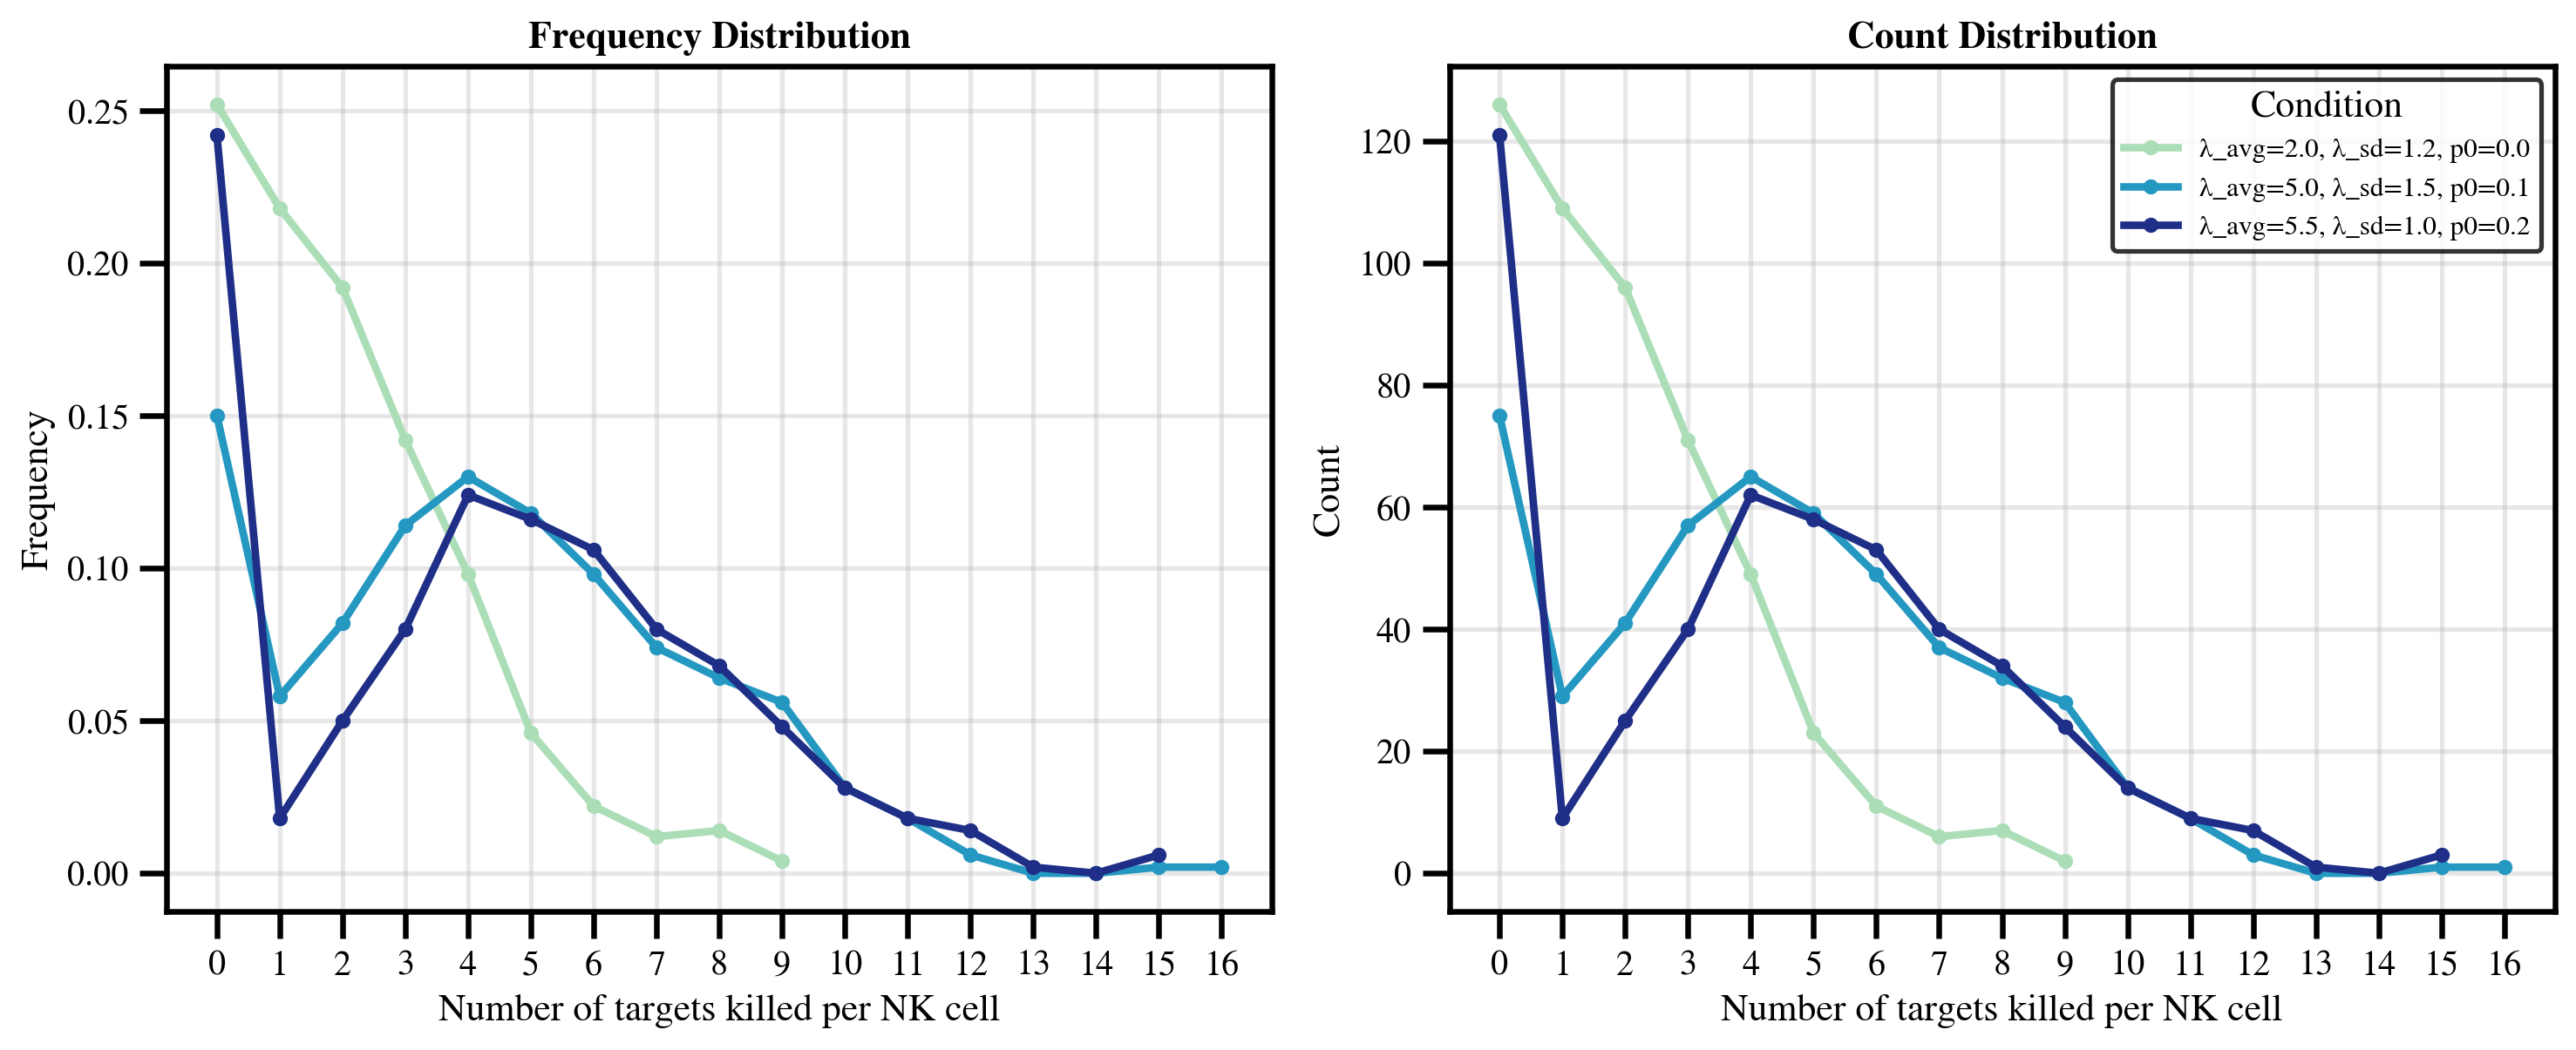

In [29]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}, p0={p_zero_list[i]}" 
    for i in range(len(lambda_avg_list))
]

cmap = get_cmap('YlGnBu')
colors = cmap(np.linspace(0.3, 0.9, len(conditions)))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=250, sharex=True)
ax_freq, ax_count = axes

for i, cond_name in enumerate(conditions):
    colour = colors[i]
    
    kills = experiment[i].get_summary()['kills']
    n_cells = len(kills)
    max_kills = int(kills.max())
    counts = np.bincount(kills, minlength=max_kills + 1)
    freq = counts / n_cells if n_cells > 0 else np.zeros_like(counts)
    x = np.arange(len(counts))
    
    ax_freq.plot(x, freq, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)
    ax_count.plot(x, counts, color=colour, linewidth=2.5, label=cond_name, marker='o', markersize=4)

ax_freq.set_title("Frequency Distribution", fontweight='bold')
ax_count.set_title("Count Distribution", fontweight='bold')
ax_freq.set_ylabel("Frequency")
ax_count.set_ylabel("Count")

for ax in (ax_freq, ax_count):
    ax.set_xlabel("Number of targets killed per NK cell")
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.grid(True, alpha=0.3)

ax_count.legend(title="Condition", frameon=True, edgecolor='black', loc='upper right', fontsize=9)
plt.tight_layout()
# plt.savefig("./synthetic_data_plots.pdf", dpi=500, bbox_inches="tight")
plt.show()


In [18]:
summary_data = []

for i in range(len(experiment)):
    exp = experiment[i]
    kills = exp.kills
    lambdas = exp.lambdas
    
    summary_data.append({
        'Experiment': i,
        'λ_avg (input)': exp.kill_lambda_avg,
        'λ_sd (input)': exp.kill_lambda_sd,
        'p_zero (input)': exp.p_zero,
        'λ_mean (actual)': np.mean(lambdas),
        'λ_std (actual)': np.std(lambdas),
        'Kills_mean': np.mean(kills),
        'Kills_std': np.std(kills),
        'Kills_min': np.min(kills),
        'Kills_max': np.max(kills),
        'Zero_kills (%)': 100 * np.sum(kills == 0) / len(kills),
    })

df_summary = pd.DataFrame(summary_data)
print("Summary Statistics for Synthetic Experiments:")
print("=" * 120)
print(df_summary.to_string(index=False))
print("=" * 120)


Summary Statistics for Synthetic Experiments:
 Experiment  λ_avg (input)  λ_sd (input)  p_zero (input)  λ_mean (actual)  λ_std (actual)  Kills_mean  Kills_std  Kills_min  Kills_max  Zero_kills (%)
          0            2.0           1.2             0.0         2.027989        1.175807       2.014   1.877712          0          9            25.2
          1            5.0           1.5             0.1         4.296177        2.220557       4.408   3.098635          0         16            15.0
          2            5.5           1.0             0.2         4.175682        2.484794       4.368   3.376474          0         15            24.2


In [19]:
type(experiment[0].get_summary()['kills'])

numpy.ndarray

## Bayesian Inference

In [ ]:
def inference_one(kills_per_cell, draws=3000, tune=3000, chains=4, seed=66):
    with pm.Model() as model:
        eta = pm.Uniform("eta", lower=-10.0, upper=10.0)
        mu_lambda = pm.Deterministic("mu_lambda", 10.0 ** eta)
        sigma_lambda = pm.HalfNormal("sigma_lambda", sigma=5.0)
        p_zero = pm.Beta("p_zero", alpha=1.0, beta=3.0)
        
        lambda_group = pm.normal("lambda_group", mu=mu_lambda, sigma=sigma_lambda)
        
        pm.ZeroInflatedPoisson(
            "kills", psi=p_zero, mu=lambda_group, observed=kills_per_cell
        )
        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=chains,
            target_accept=0.95,
            random_seed=seed,
            progressbar=True,
        )
        try:
            trace = pm.compute_log_likelihood(trace, extend_inferencedata=True)
        except Exception:
            pass
    return trace

def inference_all(
    experiment,
    labels=None,
    draws=3000,
    tune=3000,
    chains=4,
    seed=66
):
    if labels is None:
        labels = [f"cond_{i}" for i in range(len(experiment))]

    out = []
    for i in tqdm(range(len(experiment))):
        idata = inference_one(
            kills_per_cell=experiment[i].get_summary()['kills'],
            draws=draws,
            tune=tune,
            chains=chains,
            seed=seed + i
        )
        out.append((labels[i], idata))
    return out

def plot_joint_posteriors(
    idatas,
    parameters=None,
    hdi_prob=0.95,
    sample_size=2000,
    save_pdf=False,
    pdf_path="joint_posteriors.pdf",
    cmap_name="YlGnBu",
    point_size=3,
    font_scale=0.7,
):
    sns.set_context("talk", font_scale=font_scale)
    cmap = plt.colormaps.get_cmap(cmap_name)
    colors = cmap(np.linspace(0.3, 0.9, len(idatas)))
    label_to_df = {}
    for label, idata in idatas:
        posterior = idata.posterior
        if parameters is None:
            parameters = [v for v in posterior.data_vars if posterior[v].ndim <= 2]
        df = pd.DataFrame()
        for p in parameters:
            vals = posterior[p].stack(sample=("chain", "draw")).values.ravel()
            if len(vals) > sample_size:
                vals = np.random.choice(vals, sample_size, replace=False)
            df[p] = vals
        df["label"] = label
        label_to_df[label] = df
    npar = len(parameters)
    fig = plt.figure(figsize=(2.5 * npar, 2.5 * npar))
    gs = gridspec.GridSpec(npar, npar, wspace=0.15, hspace=0.15)
    gaxes = np.empty((npar, npar), dtype=object)
    for irow, rowpar in enumerate(parameters):
        for icol, colpar in enumerate(parameters):
            ax = plt.subplot(gs[irow, icol])
            gaxes[irow, icol] = ax
            if icol > irow:
                ax.axis("off")
                continue
            for color, (label, df) in zip(colors, label_to_df.items()):
                if icol == irow:
                    sns.kdeplot(
                        df[rowpar],
                        ax=ax,
                        fill=True,
                        color=color,
                        alpha=0.2,
                        linewidth=1.5,
                        label=label if irow == 0 else None,
                    )
                    lo, hi = az.hdi(df[rowpar].to_numpy(), hdi_prob=hdi_prob)
                    ax.axvline(lo, color=color, linestyle="--", linewidth=0.8)
                    ax.axvline(hi, color=color, linestyle="--", linewidth=0.8)
                else:
                    ax.scatter(
                        df[colpar],
                        df[rowpar],
                        s=point_size,
                        alpha=0.3,
                        color=color,
                        label=label if (irow == 0 and icol == 0) else None,
                    )
            if irow == npar - 1:
                ax.set_xlabel(colpar)
            else:
                ax.set_xticklabels([])
            if icol == 0:
                ax.set_ylabel(rowpar)
            else:
                ax.set_yticklabels([])
    handles, labels = gaxes[0, 0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels, loc="upper right", frameon=False)
    plt.suptitle(f"Joint posterior distributions ({int(hdi_prob*100)}% HDI)", fontsize=12, y=1.02)
    plt.tight_layout()
    if save_pdf:
        plt.savefig(pdf_path, dpi=300, bbox_inches="tight")
        print(f"Saved joint posterior plot: {pdf_path}")
    plt.show()

In [31]:
conditions = [
    f"λ_avg={lambda_avg_list[i]}, λ_sd={lambda_sd_list[i]}, p0={p_zero_list[i]}" 
    for i in range(len(lambda_avg_list))
]
idatas = inference_all(
    experiment=list(experiment.values()),
    labels=conditions,
    draws=2000,
    tune=2000,
    chains=4,
    seed=66
)

plot_joint_posteriors(
    idatas,
    parameters=["mu_lambda", "sigma_lambda", "p_zero"],
    hdi_prob=0.95,
    sample_size=1500,
    save_pdf=True,
    pdf_path="joint_posteriors.pdf"
)

  0%|          | 0/3 [00:00<?, ?it/s]Initializing NUTS using jitter+adapt_diag...
/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, sigma_lambda, p_zero, lam_cell, lambda_group]


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 52 seconds.
There were 1800 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

 33%|███▎      | 1/3 [01:06<02:13, 66.63s/it]Initializing NUTS using jitter+adapt_diag...
/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: overflow encountered in exp
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/opt/homebrew/Caskroom/miniforge/base/envs/snake/lib/python3.13/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
 33%|███▎      | 1/3 [01:12<02:24, 72.29s/it]


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'eta_interval__': array(-0.05741359), 'sigma_lambda_log__': array(1.22637728), 'p_zero_logodds__': array(-0.55824724), 'lam_cell_log__': array([6.82031423, 6.09697198, 5.36521269, 6.07954399, 7.29902897,
       6.38796763, 5.59525711, 5.47074363, 5.53186842, 7.00746616,
       6.80457667, 6.38221842, 7.04000464, 6.44686582, 5.77045426,
       5.38995732, 6.60040875, 5.74910255, 6.09643444, 6.52686439,
       6.7822127 , 5.92769123, 5.78467193, 7.16816184, 5.57161436,
       6.80167455, 6.77852894, 6.1402096 , 6.957273  , 6.82787033,
       5.91312226, 6.02800318, 6.18887043, 5.5433269 , 5.42379604,
       6.02443052, 5.34787501, 6.93621086, 6.34385992, 7.3175681 ,
       6.75587713, 6.79599338, 5.86084908, 6.98839046, 6.41227979,
       6.02011201, 5.62880026, 6.13006518, 6.5659335 , 6.38258521,
       5.73592929, 7.09717147, 6.87420176, 5.75539544, 5.8072646 ,
       5.49832268, 6.79524455, 5.32956986, 7.25147197, 6.09666341,
       6.41089079, 6.26662237, 6.78234126, 6.77701773, 5.95799726,
       6.4424383 , 5.98627763, 6.03002438, 6.83509853, 6.21272452,
       5.74910124, 5.85963467, 5.46403052, 6.2834171 , 5.39590579,
       7.11498073, 6.04828708, 7.15822317, 5.9008245 , 6.02143315,
       7.29068238, 7.24888685, 6.33415763, 6.23416814, 7.31967684,
       6.14917411, 6.47206239, 7.07365449, 6.91908863, 6.3115879 ,
       6.37872111, 6.62921079, 6.79992521, 6.17236512, 6.55177169,
       6.39240035, 5.63476964, 6.47039308, 6.75457459, 6.61167574,
       6.45614722, 6.7440661 , 6.95066038, 5.92274116, 6.11731961,
       5.48326128, 5.97997074, 6.661952  , 6.72111078, 5.8321796 ,
       7.03506524, 5.70514255, 5.8664498 , 6.07784958, 6.28890726,
       7.04674057, 5.89162775, 5.77522301, 5.90453905, 6.97838726,
       5.72097885, 6.85238436, 5.97734677, 5.59048077, 5.73541927,
       6.47019128, 6.30415318, 5.75268884, 6.86046357, 6.96573539,
       6.81374851, 5.85219772, 6.49318257, 6.56984213, 7.06114868,
       5.71448603, 6.30037265, 6.48026333, 5.59771209, 6.14431323,
       6.57277191, 6.77222388, 5.56132831, 5.50752003, 6.48993799,
       6.18057135, 5.41943563, 7.09525375, 5.52580795, 5.7867616 ,
       5.76865584, 6.35941007, 6.97131836, 7.15161416, 7.20240617,
       7.09651397, 6.32785196, 5.91449595, 6.18409775, 6.88634613,
       6.91671417, 6.04615918, 7.24309886, 5.5624633 , 5.6307607 ,
       6.21046912, 5.53626496, 6.40581663, 5.4110128 , 6.21098859,
       7.1247592 , 7.24415543, 5.61675579, 6.72389638, 5.68576967,
       5.70681349, 6.63790501, 7.30101608, 7.28790091, 6.21770371,
       6.47481343, 7.09210614, 5.52324651, 6.90066571, 5.58002244,
       5.70729297, 6.90119137, 7.03366731, 6.98025933, 5.61107054,
       6.77482157, 7.32420313, 6.17496598, 6.47039487, 6.85557695,
       7.0122223 , 6.06451942, 5.80017492, 6.87424107, 5.39960965,
       5.65490367, 6.6959367 , 7.16027889, 5.95765471, 7.24733454,
       6.56798886, 6.58799584, 5.46508895, 6.31330612, 5.3858399 ,
       5.51748184, 7.2422867 , 5.66271847, 6.32788156, 7.03228188,
       6.73594636, 7.03454983, 6.7574837 , 7.09353567, 5.80403127,
       6.78888548, 5.45310647, 5.44940881, 6.61138923, 7.10605627,
       7.08489193, 5.43894164, 7.17540296, 5.62371963, 6.81582872,
       6.91530204, 5.67053024, 6.9266272 , 6.92875517, 6.31251508,
       6.32203261, 6.01407546, 7.01587265, 7.02002828, 6.74411113,
       6.17135312, 5.47089104, 6.07400294, 5.44643302, 6.37182271,
       5.44686301, 5.77182003, 7.16959843, 5.80758803, 6.07927825,
       5.9767983 , 5.76294515, 6.93815632, 7.01108582, 6.0530341 ,
       7.27761508, 7.11114396, 5.74080169, 6.97633856, 5.99148121,
       6.61367804, 5.76545435, 6.61095318, 7.30788364, 6.98462637,
       6.07494077, 7.24152492, 7.05943403, 5.53077417, 6.29713661,
       7.03122148, 6.74330921, 5.35683711, 6.22943994, 6.7654696 ,
       6.7012323 , 5.75111733, 5.86418327, 5.86440813, 6.84226919,
       6.64596511, 5.33946396, 6.68478765, 6.25554662, 5.89506417,
       6.26060591, 6.03943939, 5.49591189, 7.05498637, 6.70208362,
       6.60926925, 6.19552552, 6.18153038, 5.95248101, 6.78357727,
       7.1654521 , 6.81343675, 6.30364939, 6.86378887, 6.23073096,
       7.13288439, 5.6832244 , 6.94078419, 6.04243852, 6.51551459,
       6.13079686, 5.78832245, 7.24745707, 5.53700165, 5.64899215,
       6.76478712, 6.24246488, 7.24041122, 6.24009914, 6.59297676,
       6.75198902, 7.08566819, 6.30618809, 5.8649522 , 6.05141291,
       6.70001917, 6.10336255, 6.65829999, 6.43432727, 7.20548834,
       5.67259347, 5.71383054, 6.52026885, 5.80261663, 7.00160581,
       6.09915485, 6.13269924, 7.03750744, 6.4019801 , 5.45226204,
       5.81530776, 7.29969023, 6.13162654, 6.24228965, 7.17139467,
       6.28189944, 5.793704  , 6.64790519, 5.8157858 , 5.5303868 ,
       6.48416023, 7.2202249 , 7.27851075, 7.00494075, 6.05706522,
       7.19088284, 6.95753507, 5.56560223, 6.49946288, 6.79232934,
       7.01000956, 6.00452299, 6.64293139, 5.36488258, 6.16841333,
       5.73313966, 6.05066527, 6.05306223, 5.42134289, 5.6502831 ,
       5.74534446, 6.90153252, 6.14187319, 5.91083948, 6.69319584,
       7.3070612 , 6.7387206 , 6.68296007, 7.23838691, 7.14484498,
       6.72424749, 6.93802909, 5.79844868, 6.11387271, 5.76696192,
       7.02199808, 6.48922073, 6.70737098, 6.94959926, 6.10657294,
       5.801166  , 7.23999877, 6.13392732, 5.50769698, 5.50052767,
       5.62198993, 5.95893458, 7.28300059, 6.2684802 , 6.62823188,
       6.60081503, 5.8181283 , 5.85927349, 6.89569555, 6.7853189 ,
       7.10787473, 6.73948211, 5.59469839, 6.72020012, 5.35502329,
       7.27178753, 6.58711002, 7.17354069, 5.56715024, 6.68239713,
       6.55787973, 5.72815982, 5.60427735, 6.85079921, 5.66519331,
       6.40577335, 7.14905977, 7.30310366, 6.18281177, 7.01222201,
       5.8706657 , 6.44711011, 6.55325611, 7.29115805, 6.38434737,
       6.05079944, 5.48345174, 5.41970577, 6.0588761 , 6.62027854,
       6.47853988, 7.04321137, 6.68506829, 6.83991832, 5.8338091 ,
       5.83078947, 6.29666463, 6.01133889, 6.19363404, 6.25274859,
       6.23740192, 5.48972935, 5.53148987, 5.96113402, 6.73108254,
       7.04367837, 5.56754457, 5.56739153, 6.34680026, 6.56262455,
       6.06242743, 6.88147044, 5.47832095, 6.72912021, 7.17454855,
       6.87160991, 7.092364  , 6.04437218, 6.63805824, 6.89289967,
       6.34190927, 5.6519098 , 5.51394339, 7.2496826 , 6.35082925,
       6.83882878, 6.70135759, 6.48626061, 5.38562451, 5.34059701,
       6.1776949 , 6.43042251, 5.39872357, 5.75834421, 7.07967649,
       5.34065513, 6.43545008, 7.0277235 , 6.84251232, 7.27483435,
       7.24821454, 5.45515668, 6.82322381, 5.43631538, 7.13288703,
       6.36374149, 6.15440459, 6.3167407 , 6.65276062, 5.54279543,
       5.40026024, 6.69373618, 5.54838206, 5.76427977, 6.7974693 ,
       6.45742459, 6.58811137, 5.57186347, 5.44027306, 6.68038521]), 'lambda_group_log__': array([ 921.50920363,  450.26494175,  220.07484872,  443.28059801,
       1484.38941808,  600.16442236,  274.95877951,  244.26963338,
        259.41103656, 1111.17671884,  907.40869706,  597.74746154,
       1147.59719726,  637.40136733,  325.79343993,  224.28133443,
        740.29211604,  320.47859148,  449.60882816,  688.14488421,
        887.83433656,  381.13904808,  331.19320841, 1302.60624533,
        269.06041216,  904.72976809,  884.4264916 ,  469.15574225,
       1056.0256884 ,  928.28988176,  376.43775032,  421.12161044,
        492.21334738,  260.3704679 ,  232.92945669,  418.47344588,
        216.66996977, 1033.7590109 ,  575.57843886, 1511.76494605,
        863.91980687,  899.32806   ,  357.52977573, 1089.82120361,
        615.61077756,  416.48603087,  284.46231275,  465.46702585,
        716.32193648,  598.12260223,  315.13551967, 1213.41828808,
        973.12325305,  322.13126052,  339.17517839,  249.38001463,
        899.63189655,  212.13927118, 1416.73540941,  449.94942832,
        614.81404523,  531.61114052,  888.91139714,  884.01284578,
        392.30721982,  633.5209453 ,  404.65426396,  420.96335036,
        935.88737406,  505.60987381,  318.78913344,  356.51560652,
        241.41808611,  541.77350878,  226.5261826 , 1235.28704253,
        429.85249507, 1290.68742797,  371.69988529,  418.24712106,
       1472.30493637, 1412.30841743,  569.81914738,  515.94391669,
       1515.58412902,  475.12004434,  651.9605265 , 1185.40422253,
       1018.00594451,  556.54962972,  595.66160442,  762.45892425,
        903.36101858,  486.11644476,  705.37993224,  603.59017689,
        286.48297208,  651.49259887,  863.86365352,  749.85453513,
        643.32261861,  854.02437267, 1048.81413811,  380.09739626,
        459.76506305,  246.82456909,  400.5653777 ,  788.38540232,
        834.84617609,  346.81653061, 1141.16063383,  305.46898108,
        357.96276413,  440.9858372 ,  545.00677085, 1155.7151024 ,
        368.66293765,  328.9945939 ,  373.06086025, 1079.5744296 ,
        311.89470324,  951.94142887,  400.35437489,  273.55201205,
        316.06166765,  651.72371343,  553.09431953,  321.37792661,
        960.49154442, 1064.90632504,  915.86422237,  353.35775164,
        666.10593444,  718.71402603, 1171.56369006,  308.82053344,
        551.00396061,  657.22119252,  275.41162661,  471.28332514,
        720.25780056,  879.44342532,  266.79179405,  252.8850079 ,
        663.34468413,  488.67452947,  231.09701319, 1212.27862679,
        257.3334744 ,  331.96767318,  325.13363756,  583.54094509,
       1070.68564221, 1282.28370415, 1349.07175973, 1214.5440443 ,
        565.1594957 ,  376.27856939,  490.24962827,  984.43420843,
       1014.78175999,  428.62396914, 1404.64669913,  266.22833666,
        285.01970859,  504.63730318,  259.91395248,  610.94444032,
        229.2999525 ,  503.73547435, 1248.58715745, 1406.04906221,
        281.07764546,  838.16878212,  300.53358102,  307.15007432,
        769.99260019, 1488.54294387, 1468.79804524,  507.59403418,
        653.85478743, 1208.61694779,  257.19624868,  999.18204413,
        270.89239924,  307.13022851,  999.11948883, 1139.02145915,
       1080.58752811,  280.24399946,  881.63548676, 1523.19090932,
        485.7428551 ,  650.8966516 ,  954.74115875, 1115.41055229,
        436.72474043,  335.38474613,  973.68383472,  226.50387658,
        290.78201577,  815.48650228, 1293.00022646,  393.00464453,
       1410.92857375,  718.52309693,  732.23096031,  242.55336335,
        557.17894942,  224.39758549,  254.9098623 , 1403.23578483,
        294.16156437,  565.25713865, 1137.90813598,  848.01579718,
       1141.17996595,  867.06322911, 1210.78817537,  336.85667587,
        894.02627207,  238.57655459,  237.46628121,  749.58223291,
       1225.04854905, 1199.17575383,  235.05289541, 1312.71712943,
        282.51045824,  918.50248793, 1012.7994849 ,  295.90217118,
       1024.70890284, 1027.74493355,  556.82849912,  563.48703118,
        414.78641108, 1120.23884987, 1125.31271505,  855.69894599,
        483.69053644,  242.74715912,  439.4752525 ,  237.545454  ,
        591.22681506,  238.59560015,  326.20622357, 1305.4354492 ,
        337.72116023,  443.28479467,  399.36450613,  323.98917795,
       1035.96746129, 1114.07979064,  431.23684963, 1454.26034608,
       1230.68828114,  317.8913081 , 1075.9729221 ,  405.64272493,
        751.30549952,  324.39229375,  748.1937293 , 1498.79620003,
       1086.50023752,  441.52945288, 1401.25428599, 1169.34085012,
        257.1936481 ,  548.71378833, 1136.61186577,  854.79109191,
        217.86224199,  514.17197976,  872.51275134,  818.74514161,
        321.12676853,  357.02607676,  357.97745422,  941.69535965,
        775.76147423,  213.86107676,  806.80939331,  525.82219634,
        368.72915006,  529.96643203,  424.76294419,  250.34023232,
       1164.82979301,  819.73194856,  747.54466052,  496.97966332,
        489.71857762,  390.7901181 ,  889.75233706, 1300.34466811,
        916.6637636 ,  553.2896636 ,  963.34457201,  514.62976012,
       1259.28786709,  299.42432831, 1039.27939517,  427.07218775,
        682.09809398,  465.25367198,  333.03751504, 1409.67788932,
        259.32812017,  290.13635104,  872.77262152,  520.64851681,
       1401.13714877,  519.20933171,  735.85498327,  862.10118752,
       1200.10984114,  554.50924238,  358.67326229,  430.86571481,
        818.00690771,  452.76550874,  784.64190334,  629.54705317,
       1351.9358978 ,  295.94686513,  309.44835883,  684.25351562,
        336.11777426, 1104.03439817,  450.41792368,  466.55850437,
       1143.39057691,  609.79186619,  238.37829283,  340.22920915,
       1484.72155818,  465.77896136,  520.78050351, 1307.86798306,
        541.1501269 ,  334.53259698,  776.57689121,  341.67222353,
        257.17864779,  659.75203786, 1372.95430676, 1454.6091305 ,
       1108.20527143,  432.46782574, 1333.26645319, 1056.75038313,
        266.61098416,  670.95993793,  896.18461072, 1114.20378688,
        411.27339695,  773.12226515,  220.23611143,  483.68937589,
        315.16185715,  430.16908999,  431.4710407 ,  231.93825813,
        290.12738654,  319.19264555,  999.83671558,  471.31053835,
        374.53932229,  812.00986931, 1496.65576541,  850.04384086,
        804.45497723, 1397.09290402, 1272.81534354,  838.30515683,
       1036.15555824,  334.98786235,  458.05998094,  325.38528641,
       1127.64162173,  663.77607312,  824.98922967, 1048.26123879,
        455.27477357,  336.3992155 , 1400.61772984,  467.90106475,
        252.43107049,  249.89369917,  283.22954139,  392.93340984,
       1460.49335351,  533.12816503,  761.4199257 ,  742.12732865,
        342.04743746,  355.88238703,  994.49652554,  890.47377426,
       1228.3259273 ,  851.11453362,  274.86816589,  833.8506846 ,
        218.35900358, 1445.78415465,  731.66015009, 1311.14495978,
        268.24938352,  803.90556626,  710.14689159,  313.88406329,
        278.09097642,  949.79094192,  294.75812849,  610.28020135,
       1278.02358651, 1491.24751145,  489.18178711, 1115.47888104,
        361.11063844,  636.22005153,  706.65732057, 1473.31896642,
        597.89165701,  431.00883016,  246.00330874,  232.4635465 ,
        433.22811369,  756.4403672 ,  657.23741369, 1150.15467735,
        805.74017345,  939.28626575,  347.97546795,  346.52643675,
        547.73876936,  414.44219718,  494.72381864,  525.2799051 ,
        517.49560187,  248.66655863,  257.52682696,  393.89441798,
        844.16090993, 1151.37166587,  268.53406324,  266.87823809,
        576.64207164,  713.4393566 ,  434.95497645,  980.41226966,
        244.46348295,  842.11174468, 1312.29029255,  969.65018345,
       1209.54858006,  427.5841072 ,  769.8651771 ,  990.98992401,
        574.07954186,  290.79475186,  252.94827763, 1413.03939281,
        577.86770975,  939.98518502,  818.97239606,  661.01304425,
        223.36645516,  213.81418261,  488.38477604,  626.44752981,
        227.45663641,  322.492924  , 1194.3242467 ,  214.01166576,
        629.10211442, 1133.38571986,  943.55177069, 1448.81880107,
       1410.46119322,  240.16809947,  924.91228717,  236.05153115,
       1258.36507683,  587.11334407,  475.64663424,  558.76456205,
        780.9316089 ,  261.80542356,  226.71536999,  814.08598899,
        263.06360657,  323.79721522,  901.58189707,  642.77272967,
        732.29423847,  269.2787817 ,  236.60831532,  801.67079335])}

Logp initial evaluation results:
{'eta': np.float64(-1.39), 'sigma_lambda': np.float64(-0.84), 'p_zero': np.float64(-1.27), 'lam_cell': np.float64(-1810.88), 'lambda_group': np.float64(-1813.29), 'kills': np.float64(-inf)}
You can call `model.debug()` for more details.